In [5]:
from IPython.display import Image, display

import graphviz
from typing import Literal
import random
from collections import defaultdict, deque
from dataclasses import dataclass
from typing import List, Optional
from openai import OpenAI,AsyncOpenAI
from dotenv import load_dotenv
import uuid
import asyncio

load_dotenv()

True

![framework](./resources/stand-alone%20multi%20agent%20framework_v2.png)

### Async Version

In [6]:
class iAgent:
    """
    simple demo
    """
    def __init__(self,name: str,description: str):
        self.name = name
        self.description = description
        self.async_client = AsyncOpenAI()
        self.client = OpenAI()


    def chat(self, messages: list|str,stream: bool = False):
        if isinstance(messages, str):
            messages = [{"role": "user", "content": messages}]
        response = self.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "system", "content": self.description}] + messages,
                stream=stream
            )
        
        if not stream:
            return [{"role": "assistant", "content": response.choices[0].message.content,"sender": self.name}]
        else:
            streamed_response = ""

            for chunk in response:
                try:
                    chunk_content = chunk.choices[0].delta.content
                    print(chunk_content or "", end="")
                    if chunk_content is not None:
                        streamed_response = streamed_response + chunk_content
                except:
                    pass
            return {"role": "assistant", "content": streamed_response,"sender": self.name}

    async def chat_async(self, messages: list|str,stream: bool = False):
        if isinstance(messages, str):
            messages = [{"role": "user", "content": messages}]
        response = await self.async_client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "system", "content": self.description}] + messages,
                stream=stream
            )
        
        if not stream:
            return [{"role": "assistant", "content": response.choices[0].message.content,"sender": self.name}]
        else:
            streamed_response = ""

            async for chunk in response:
                try:
                    chunk_content = chunk.choices[0].delta.content
                    print(chunk_content or "", end="")
                    if chunk_content is not None:
                        streamed_response = streamed_response + chunk_content
                except:
                    pass
            return {"role": "assistant", "content": streamed_response,"sender": self.name}

In [7]:
example_agent = iAgent("example","You are a helpful assistant")
res1 = example_agent.chat("Hello, Who are you?")
res2 = await example_agent.chat_async("Hello, Who are you?")

print(res1)
print(res2)

[{'role': 'assistant', 'content': "Hello! I'm an AI assistant here to help you with information, answer questions, and assist with a variety of topics. How can I help you today?", 'sender': 'example'}]
[{'role': 'assistant', 'content': "Hello! I’m an AI language model created to assist you with a variety of questions and tasks. Whether you need information, advice, or help with writing, I'm here to help. How can I assist you today?", 'sender': 'example'}]


In [8]:
@dataclass
class AgentSchema:
    """
    This class defines the schema of the agent used for the handoff process.
    """
    name: str
    transfer_to_me_description: str
    agent: iAgent
    relations: Optional[List[str]] = None # agent names that this agent can transfer to
    as_entry: Optional[bool] = False
    as_exit: Optional[bool] = False


In [21]:
class Group:
    def __init__(self, 
                 participants: list[AgentSchema], 
                 model_client: OpenAI = AsyncOpenAI()):
        """ 
        Initializes the group with the given participants and model client.

        Args:
            participants (list[AgentSchema]): A list of AgentSchema objects representing the participants in the group.
            model_client (OpenAI, optional): The OpenAI client used for the handoff process. Defaults to OpenAI().

        Raises:
            ValueError: If the group structure is not valid.
        """
        self.participants = participants
        self.model_client = model_client
        self.entry_agent = next((p for p in participants if p.as_entry), random.choice(participants))
        self.current_agent = {"DEFAULT":self.entry_agent}
        self.exit_agent = next((p for p in participants if p.as_exit), None)
        self.agent_map = {p.name: p for p in participants}
        self.handoff_tools = []
        self.participants_order_map = self._build_participant_order_map()
        self.group_structure = self._decide_group_structure()

    def reset(self,
              thread_id:Optional[str] = None):
        """
        Resets the state of the framework by setting the current agent to the first participant
        that has the 'as_entry' attribute set to True.
        """
        self.entry_agent = next((p for p in self.participants if p.as_entry), random.choice(self.participants))
        if thread_id:
            self.current_agent[thread_id] = self.entry_agent
        else:
            self.current_agent = {"DEFAULT":self.entry_agent}

    async def handoff_one_turn(self, 
                         messages: list|str,
                         model:str="gpt-4o-mini",
                         next_speaker_select_mode:Literal["order","auto","random"]="auto",
                         include_current:bool = True,
                         thread_id: str = "DEFAULT",
                         verbose=False
                         ):
        """ 
        Performs a single turn of the handoff process.

        Args:
            messages (list|str): The messages to be used for the handoff process.
            model (str, optional): The model used for the handoff process. Defaults to "gpt-4o-mini".
            next_speaker_select_mode (Literal["order","auto","random"], optional): The mode used to select the next speaker. Defaults to "auto".
            include_current (bool, optional): Whether to include the current agent in the handoff tools. Defaults to True.
            thread_id (str, optional): The thread ID used to keep track of the current agent. Defaults to "DEFAULT".
            verbose (bool, optional): Whether to print the handoff process. Defaults to False.
        """

        if next_speaker_select_mode == "order":
            if self.group_structure != "CONNECTED":
                raise ValueError("next_speaker_select_mode 'order' is only supported when group_structure is 'CONNECTED'")
            next_agent = self.participants_order_map[self.current_agent.get(thread_id,self.entry_agent).name]
            if verbose:
                current_agent = self.current_agent.get(thread_id,self.entry_agent).name
                print(f"\n-> handoff from {current_agent} to {next_agent} (order mode)")
            self.current_agent[thread_id] = self.agent_map[next_agent]
            return next_agent
        
        elif next_speaker_select_mode == "random":
            next_agent = random.choice(self.agent_names)
            if verbose:
                current_agent = self.current_agent.get(thread_id,self.entry_agent).name
                print(f"\n-> handoff from {current_agent} to {next_agent} (random mode)")
            self.current_agent[thread_id] = self.agent_map[next_agent]
            return next_agent
 
        elif next_speaker_select_mode == "auto":
            
            self._build_current_handoff_tools(include_current=include_current,thread_id=thread_id)
    
            if isinstance(messages, str):
                messages = [{"role": "user", "content": messages}]
            messages = [{"role": "system", "content":"deciding which agent to transfer to"}] + messages

            response = await self.model_client.chat.completions.create(
                        model=model,
                        messages=messages,
                        tools=self.handoff_tools,
                        tool_choice="required"
                    )
            next_agent = response.choices[0].message.tool_calls[0].function.name

            if next_agent in self.agent_names:
                if self.current_agent.get(thread_id,self.entry_agent).name != next_agent and verbose:
                    print("\n-> handoff from {} to {} (auto mode)".format(self.current_agent.get(thread_id,self.entry_agent).name, next_agent))
                self.current_agent[thread_id] = self.agent_map[next_agent]
            else:
                raise ValueError(f"Handoff to unknown agent: {next_agent}")

            return next_agent
    
        else:
            raise ValueError(f"Unknown next_speaker_select_mode: {next_speaker_select_mode} , Currently only 'order', 'random' and 'auto' are supported")

    async def handoff(self, 
                messages: list|str,
                model:str="gpt-4o-mini",
                handoff_max_turns:int=10,
                next_speaker_select_mode:Literal["order","auto","random"]="auto",
                include_current = True,
                thread_id: str = "DEFAULT",
                verbose=False
                ):

        """ 
        Performs the handoff process.

        Args:
            messages (list|str): The messages to be used for the handoff process.
            model (str, optional): The model used for the handoff process. Defaults to "gpt-4o-mini".
            handoff_max_turns (int, optional): The maximum number of turns to perform the handoff process. used in auto mode. Defaults to 10.
            next_speaker_select_mode (Literal["order","auto","random"], optional): The mode used to select the next speaker. Defaults to "auto".
            include_current (bool, optional): Whether to include the current agent in the handoff tools. Defaults to True.
            thread_id (str, optional): The thread ID used to keep track of the current agent. Defaults to "DEFAULT".
            verbose (bool, optional): Whether to print the handoff process. Defaults to False.
        """

        next_agent = await self.handoff_one_turn(messages,model,next_speaker_select_mode,include_current,thread_id,verbose)
        if next_speaker_select_mode != "auto" or handoff_max_turns == 1:
            return next_agent
        next_next_agent = await self.handoff_one_turn(messages,model,"auto",include_current,thread_id,verbose)
        while next_next_agent != next_agent and handoff_max_turns > 1:
            next_agent = next_next_agent
            next_next_agent = await self.handoff_one_turn(messages,model,"auto",include_current,thread_id,verbose)
            handoff_max_turns -= 1
        return next_agent


    async def chat(self, 
             messages: list|str,
             model:str="gpt-4o-mini",
             next_speaker_select_mode:Literal["auto","random"]="auto",
             entry_agent:str=None,
             thread_id: str = None,
             verbose=False
             ):
        
        """ 
        Performs a chat conversation with the group.

        Args:
            messages (list|str): The messages to be used for the chat conversation.
            model (str, optional): The model used for the chat conversation. Defaults to "gpt-4o-mini".
            next_speaker_select_mode (Literal["auto","random"], optional): The mode used to select the next speaker. Defaults to "auto".
            entry_agent (str, optional): The name of the agent to start the conversation. Defaults to None. You can set it to overwirte the current agent
            thread_id (str, optional): The thread ID used to keep track of the current agent. Defaults to None.
            verbose (bool, optional): Whether to print the chat conversation. Defaults to False.

        Returns:
            list: A list of messages exchanged during the chat conversation.
        """

        thread_id = self._generate_thread_id() if thread_id is None else thread_id

        if self.group_structure not in ["CONNECTED","CUSTOM"]:
            raise ValueError("chat is only supported when group_structure is 'CONNECTED' or 'CUSTOM'")

        if entry_agent and entry_agent in self.agent_names:
            self.current_agent[thread_id] = self.agent_map[entry_agent]
        if isinstance(messages, str):
            messages = [{"role": "user", "content": messages}]
        next_agent = await self.handoff(messages,model,10,next_speaker_select_mode,True,thread_id,verbose)

        response = await self.agent_map[next_agent].agent.chat_async(messages)
        if verbose:
            print(f"\n\n[{next_agent}] \n\n {response[0]['content']}")

        return response


    async def task(self,
             task:str,
             model:str="gpt-4o-mini",
             thread_id: Optional[str] = None,
             verbose=False
            ):
        
        """ 
        Performs a task with the group.(Notic: current only support sequential task one by one)

        Args:
            task (str): The task to be performed.
            model (str, optional): The model used for the task. Defaults to "gpt-4o-mini".
            thread_id (str, optional): The thread ID used to keep track of the current agent. Defaults to None.
            verbose (bool, optional): Whether to print the task. Defaults to False.

        Returns:
            list: A list of messages exchanged during the task.
        """

        thread_id = self._generate_thread_id() if thread_id is None else thread_id

        if self.group_structure != "SEQUENCE":
            raise ValueError("task is only supported when group_structure is 'SEQUENCE' and SEQUENCE must have both entry and exit agents")

        messages = [{"role": "user", "content": task}]
        next_agent = self.entry_agent.name
        result = []
        while next_agent != self.exit_agent.name:
            response = await self.agent_map[next_agent].agent.chat_async(messages)
            if verbose:
                print(f"\n\n[{next_agent}] \n\n {response[0]['content']}")
            result.extend(response)
            messages.extend(response)
            next_agent = await self.handoff(messages,model,1,"auto",False,thread_id,verbose)
            messages.append({"role": "user", "content": "transfer to {} ,based on the previous conversation do you job".format(next_agent)})

        response = await self.agent_map[next_agent].agent.chat_async(messages)
        if verbose:
            print(f"\n\n[{next_agent}] \n\n {response[0]['content']}")
        result.extend(response)

        self.reset(thread_id)
        return result

    async def discussion(self,
                   topic:str,
                   model:str="gpt-4o-mini",
                   max_turns:int=5,
                   next_speaker_select_mode:Literal["order","auto","random"]="order",
                   thread_id:Optional[str] = None,
                   verbose=False
                   ):
        
        """ 
        Performs a discussion with the group.

        Args:
            topic (str): The topic of the discussion.
            model (str, optional): The model used for the discussion. Defaults to "gpt-4o-mini".
            max_turns (int, optional): The maximum number of turns to perform the discussion. Defaults to 5.
            next_speaker_select_mode (Literal["order","auto","random"], optional): The mode used to select the next speaker. Defaults to "order".
            thread_id (str, optional): The thread ID used to keep track of the current agent. Defaults to None.
            verbose (bool, optional): Whether to print the discussion. Defaults to False.

        Returns:
            list: A list of messages exchanged during the discussion.
        """

        thread_id = self._generate_thread_id() if thread_id is None else thread_id

        if self.group_structure != "CONNECTED":
            raise ValueError("discussion is only supported when group_structure is 'CONNECTED'")
        content = topic
        messages = [{"role": "user", "content": content}]
        next_agent = self.current_agent.get(thread_id,self.entry_agent).name
        result = []
        while max_turns > 0:
            response = await self.agent_map[next_agent].agent.chat_async(messages)
            if verbose:            
                print(f"\n[{next_agent}] \n\n {response[0]['content']}")
            result.extend(response)
            messages.extend(response)
            next_agent = await self.handoff(messages,model,1,next_speaker_select_mode,False,thread_id,verbose)
            messages.extend([{"role": "user", "content": "transfer to {} ,consider your own previous opinion and the previous speaker's opinion, and then give your own opinion".format(next_agent)}])
            max_turns -= 1
        self.reset(thread_id=thread_id)

        return result
            
    @property
    def agent_names(self):
        """
        Returns:
            list: A list of names of all participants.
        """
        return [p.name for p in self.participants]
    
    @property
    def relations(self):
        """
        Returns:
            list: A list of tuples representing the relations between participants.
                Each tuple contains the name of a participant and the name of a related participant.
        """
        relations = [("START", self.entry_agent.name)]
        if self.exit_agent:
            relations.append((self.exit_agent.name, "END"))
        if all(not hasattr(p, 'relations') or p.relations is None for p in self.participants):
            for i in range(len(self.participants)):
                for j in range(len(self.participants)):
                    if i != j:
                        relations.append((self.participants[i].name, self.participants[j].name))
        else:
            for p in self.participants:
                if hasattr(p, 'relations') and isinstance(p.relations, list):
                    relations.extend((p.name, r) for r in p.relations)
        return relations
    
    @property
    def relation_agents(self):
        """
        Returns:
            dict: A dictionary where the keys are participant names and the values are lists of AgentSchema objects
                representing the related agents.
        """
        if self.group_structure == "CUSTOM" or self.group_structure == "SEQUENCE":
            return {p.name: [self.agent_map[r] for r in p.relations] if p.relations else [] for p in self.participants}
        elif self.group_structure == "CONNECTED":
            return {p.name: [a for a in self.participants if a.name != p.name] for p in self.participants}
    

    def draw_relations(self,thread_id: str = "DEFAULT"):
        """ 
        Returns:
            bytes: A PNG image of the graph representing the relations between participants.
        """
        dot = graphviz.Digraph(format='png')
        dot.node("START", "START", shape='rect', color='gray', fontcolor='gray')
        if self.exit_agent:
            dot.node("END", "END", shape='rect', color='gray', fontcolor='gray')
        for p in self.participants:
            dot.node(p.name, p.name, color='orange' if p.name == self.current_agent.get(thread_id,self.entry_agent).name else 'black')
        for r in self.relations:
            dot.edge(r[0], r[1])
        return dot.pipe()

    def _build_current_handoff_tools(self, include_current=True,thread_id: str = "DEFAULT"):
        """ 
        Builds the handoff tools based on the current agent and its related agents.

        Args:
            include_current (bool, optional): Whether to include the current agent in the handoff tools. Defaults to True.

        Returns:
            list: A list of handoff tools.
        """
        self.handoff_tools = [self._build_agent_schema(self.current_agent.get(thread_id,self.entry_agent))] if include_current else []
        self.handoff_tools.extend(self._build_agent_schema(r) for r in self.relation_agents[self.current_agent.get(thread_id,self.entry_agent).name])

    @staticmethod
    def _build_agent_schema(agent: AgentSchema):
        """
        Builds the schema for the given agent. 
        """
        return {
            "type": "function",
            "function": {
                "name": agent.name,
                "description": agent.transfer_to_me_description,
                "parameters": {"type": "object", "properties": {}, "required": []}
            }
        }
    
    def _build_participant_order_map(self):
        """
        Builds a map of participants in order.

        Returns:
            dict: A dictionary mapping participant names to the next participant in order.
        """
        return {p.name: self.participants[(i+1) % len(self.participants)].name for i, p in enumerate(self.participants)}
    

    def _decide_group_structure(self):
        """ 
        Decides the group structure based on the participants and their relations.

        Returns:
            str: The group structure.

        Raises:
            ValueError: If the group structure is not valid.
        """
        # if all participants do not have relations, then group_structure is CONNECTED
        if all(not hasattr(p, 'relations') or p.relations is None for p in self.participants):
            return "CONNECTED"
        # if any participant has relations, and entry and exit agents are defined, and no circular relations, then group_structure is SEQUENCE
        if any(hasattr(p, 'relations') and p.relations for p in self.participants) and self.entry_agent and self.exit_agent:
            if self._is_valid_sequence(self.relations):
                return "SEQUENCE"
            else:
                print("[Warning] You may want to construct a SEQUENCE but now this is an invalid SEQUENCE, A SEUQENCE must have both entry and exit agents and no circular relations, Setting group_structure to CUSTOM temporarily")
        return "CUSTOM"
    
 
    @staticmethod
    def _is_valid_sequence(relations):
        """ 
        Checks if the given relations form a valid sequence.

        Args:
            relations (list): A list of tuples representing the relations between participants.

        Returns:
            bool: True if the relations form a valid sequence, False otherwise.
        """
        # Build the graph
        graph = defaultdict(list)
        reverse_graph = defaultdict(list)
        nodes = set()
        for u, v in relations:
            graph[u].append(v)
            reverse_graph[v].append(u)
            nodes.update([u, v])

        # Check for cycles using DFS
        def has_cycle(v, visited, rec_stack):
            visited.add(v)
            rec_stack.add(v)
            for neighbor in graph[v]:
                if neighbor not in visited:
                    if has_cycle(neighbor, visited, rec_stack):
                        return True
                elif neighbor in rec_stack:
                    return True
            rec_stack.remove(v)
            return False

        visited = set()
        rec_stack = set()
        for node in list(graph.keys()):  # Iterate over a list of the dictionary keys
            if node not in visited:
                if has_cycle(node, visited, rec_stack):
                    print("[SEQUENCE INVALID] Cycle detected")
                    return False

        # Check if all nodes are reachable from 'START'
        def bfs_reachable_from_start(start):
            queue = deque([start])
            visited = set()
            while queue:
                node = queue.popleft()
                if node not in visited:
                    visited.add(node)
                    queue.extend(graph[node])
            return visited

        # Check if all nodes can reach 'END'
        def bfs_reachable_to_end(end):
            queue = deque([end])
            visited = set()
            while queue:
                node = queue.popleft()
                if node not in visited:
                    visited.add(node)
                    queue.extend(reverse_graph[node])
            return visited

        reachable_from_start = bfs_reachable_from_start('START')
        reachable_to_end = bfs_reachable_to_end('END')

        if nodes != reachable_from_start:
            missing_nodes = nodes - reachable_from_start
            print(f"[SEQUENCE INVALID] Nodes not reachable from START: {missing_nodes}")
            return False

        if nodes != reachable_to_end:
            missing_nodes = nodes - reachable_to_end
            print(f"[SEQUENCE INVALID] Nodes not reachable to END: {missing_nodes}")
            return False

        return True
    
    @staticmethod
    def _generate_thread_id():
        """ 
        Generates a random thread ID by using uuid
        """
        return str(uuid.uuid4())

Group Structure:  CONNECTED


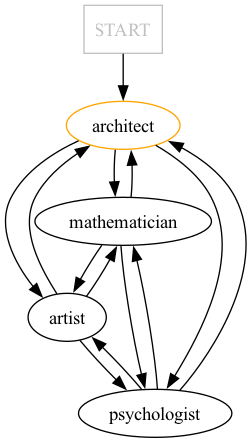

In [11]:
mathematician = iAgent(name="mathematician", description="You are a mathmatician,reply use daily language")
artist = iAgent(name="artist", description="You are an artist,reply use daily language")
architect = iAgent(name="architect", description="You are an architect,reply use daily language")
psychologist = iAgent(name="psychologist", description="You are a psychologist,reply use daily language")

mathematician_schema = AgentSchema(name="mathematician",
                            transfer_to_me_description="Call me if you have any questions about math.",
                            agent=mathematician,)

artist_schema = AgentSchema(name="artist",
                            transfer_to_me_description="Call me if you have any questions about art.",
                            agent=artist)

psychologist_schema = AgentSchema(name="psychologist",
                            transfer_to_me_description="Call me if you have any questions about psychology.",
                            agent=psychologist)

architect_schema = AgentSchema(name="architect",
                            transfer_to_me_description="Call me if you have any questions about architecture.",
                            agent=architect)

g = Group(participants=[mathematician_schema, artist_schema, architect_schema, psychologist_schema])

print("Group Structure: ", g.group_structure)

display(Image(g.draw_relations()))

In [12]:
res = await g.discussion("what is beauty",next_speaker_select_mode="order",max_turns=5,verbose=True,thread_id="0")


[architect] 

 Beauty is one of those things that's hard to pin down because it can mean something different to everyone. Generally, it refers to qualities that give pleasure to our senses, like a stunning piece of art, a breathtaking landscape, or even an interesting design in a building. It’s often tied to things like harmony, balance, and proportion. In architecture, for example, a beautiful structure might blend well with its surroundings, feel inviting, and serve its purpose effectively. Ultimately, beauty is about what resonates with us personally, often making us stop and appreciate the world around us.

-> handoff from architect to psychologist (order mode)

[psychologist] 

 Sure! Building on the previous ideas about beauty being subjective and tied to personal experiences, I would say that beauty also encompasses emotional and psychological elements. It's not just about what we see; it can evoke feelings, memories, and connections. For instance, a place might be beautiful no

In [13]:
async def async_chat_demo():
    prompts = ["what is art?","how to learn math?","what is psychology?","what is architecture?"]
    thread_ids = ["1","2","3","4"]

    # Create a list to store the results of asynchronous calls
    # results = []

    # Asynchronously call the function for each prompt
    tasks = [g.chat(prompt,next_speaker_select_mode="auto",verbose=False,thread_id=thread_id) for prompt,thread_id in zip(prompts,thread_ids)]

    # Gather and run the tasks concurrently
    # results = await asyncio.gather(*tasks)

    for answer in asyncio.as_completed(tasks):
        print(await answer)

await async_chat_demo()

[{'role': 'assistant', 'content': "Psychology is the study of the mind and behavior. It looks at how we think, feel, and act, both individually and in social settings. Psychologists try to understand things like emotions, thoughts, and motivations, and how these elements influence our actions and interactions with others. Essentially, it's a way to understand what makes us tick and how we relate to ourselves and the world around us.", 'sender': 'psychologist'}]
[{'role': 'assistant', 'content': "Architecture is basically the art and science of designing buildings and other structures. It’s about creating spaces that are functional, safe, and enjoyable to be in. Think of it as blending creativity with practicality—making sure a building looks good while also serving its purpose, like being a home, office, or public space. Architects consider things like the environment, materials, and how people will use the space. It's all about shaping the places we live, work, and play!", 'sender': '

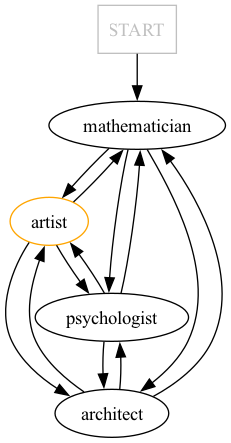

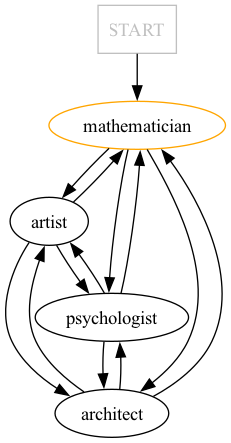

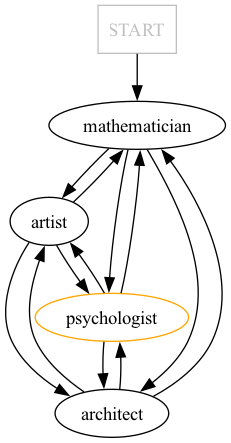

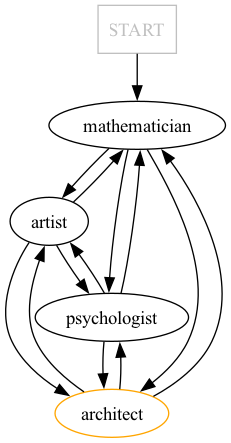

In [14]:
display(Image(g.draw_relations(thread_id="1")))
display(Image(g.draw_relations(thread_id="2")))
display(Image(g.draw_relations(thread_id="3")))
display(Image(g.draw_relations(thread_id="4")))

### CUSTOM STRUCTURE

Group Structure:  CUSTOM


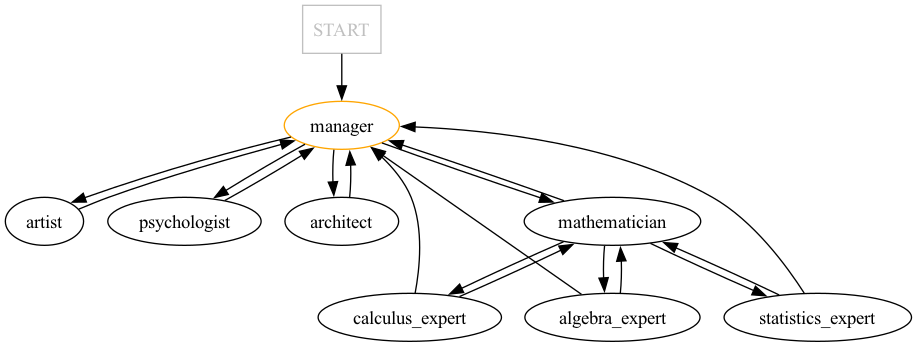

In [15]:
manager = iAgent(name="manager", description="You are a manager,determine which agent to transfer to")

mathematician = iAgent(name="mathematician", description="You are a mathmatician,reply use daily language")
artist = iAgent(name="artist", description="You are an artist,reply use daily language")
architect = iAgent(name="architect", description="You are an architect,reply use daily language")
psychologist = iAgent(name="psychologist", description="You are a psychologist,reply use daily language")

calculus_expert = iAgent(name="calculus_expert", description="You are a calculus expert,reply use daily language")
algebra_expert = iAgent(name="algebra_expert", description="You are an algebra expert,reply use daily language")
statistics_expert = iAgent(name="statistics_expert", description="You are a statistics expert,reply use daily language")

manager_schema = AgentSchema(name="manager",
                            transfer_to_me_description="Call me if you do not know which agent to transfer to.",
                            agent=manager,
                            relations=["mathematician", "artist", "psychologist", "architect"],
                            as_entry=True)

artist_schema = AgentSchema(name="artist",
                            transfer_to_me_description="Call me if you have any questions about art.",
                            agent=artist,
                            relations=["manager"])

psychologist_schema = AgentSchema(name="psychologist",
                            transfer_to_me_description="Call me if you have any questions about psychology.",
                            agent=psychologist,
                            relations=["manager"])

architect_schema = AgentSchema(name="architect",
                            transfer_to_me_description="Call me if you have any questions about architecture.",
                            agent=architect,
                            relations=["manager"])

mathematician_schema = AgentSchema(name="mathematician",
                            transfer_to_me_description="Call me if you have any questions about math.",
                            agent=mathematician,
                            relations=["calculus_expert", "algebra_expert", "statistics_expert","manager"])

calculus_expert_schema = AgentSchema(name="calculus_expert",
                            transfer_to_me_description="Call me if you have any questions about calculus.",
                            agent=calculus_expert,
                            relations=["mathematician","manager"])

algebra_expert_schema = AgentSchema(name="algebra_expert",
                            transfer_to_me_description="Call me if you have any questions about algebra.",
                            agent=algebra_expert,
                            relations=["mathematician","manager"])

statistics_expert_schema = AgentSchema(name="statistics_expert",
                            transfer_to_me_description="Call me if you have any questions about statistics.",
                            agent=statistics_expert,
                            relations=["mathematician","manager"])


g = Group(participants=[manager_schema, 
                        artist_schema, psychologist_schema, architect_schema, mathematician_schema, 
                        calculus_expert_schema, algebra_expert_schema, statistics_expert_schema])

print("Group Structure: ", g.group_structure)

display(Image(g.draw_relations()))


-> handoff from manager to mathematician (auto mode)

-> handoff from mathematician to statistics_expert (auto mode)


[statistics_expert] 

 Sure! Statistics is basically the science of collecting, analyzing, interpreting, and presenting data. Think of it as a toolbox to help us understand numbers and patterns in information.

Here’s a simpler breakdown:

1. **Collecting Data**: This is like gathering clues in a mystery. You might survey people, conduct experiments, or observe behaviors to get information.

2. **Analyzing Data**: Once you have your data, you want to make sense of it. This could mean calculating averages (like finding the average score of a class) or looking for trends (like how sales change over months).

3. **Interpreting Results**: After analysis, you figure out what the results actually mean. For example, if you find that more people prefer a certain brand, you might conclude that it’s more popular.

4. **Presenting Data**: Finally, you share your findings in a wa

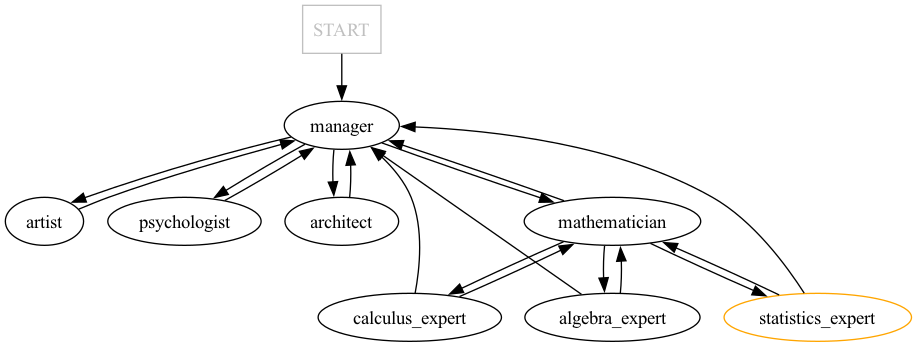

In [16]:
response = await g.chat("expalin the concept of statistics",verbose=True,thread_id="0")
display(Image(g.draw_relations(thread_id="0")))


-> handoff from statistics_expert to manager (auto mode)

-> handoff from manager to psychologist (auto mode)


[psychologist] 

 I'm sorry to hear that you're feeling this way. It's completely normal to feel sad sometimes. Do you want to talk about what's been bothering you? Sometimes sharing can help lighten the load a bit.


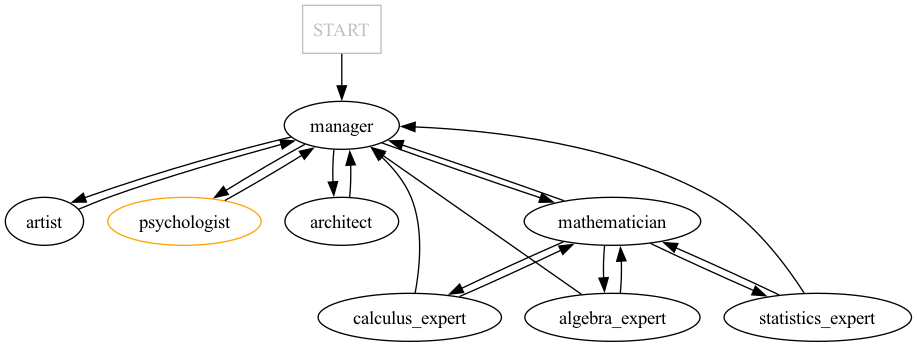

In [17]:
response =  await g.chat("I feel sad",verbose=True,thread_id="0")
display(Image(g.draw_relations(thread_id="0")))

### SEQUENCE STRUCTURE

Group Structure:  SEQUENCE


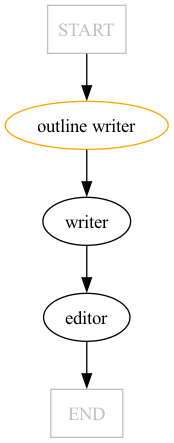

In [18]:
outline_agent = iAgent(name="outline writer", description="You are an outline writer who are good at organizing ideas")
writer = iAgent(name="writer", description="You are a writer who are good at writing drafts")
editor = iAgent(name="editor", description="You are an editor who are good at editing articles and making them more readable")

outline_writer_schema = AgentSchema(name="outline writer",
                                    transfer_to_me_description="Call me if you need help organizing your ideas.",
                                    agent=outline_agent,
                                    relations=["writer"],
                                    as_entry=True)

writer_schema = AgentSchema(name="writer",
                            transfer_to_me_description="Call me if you need help writing articles.",
                            agent=writer,
                            relations=["editor"])

editor_schema = AgentSchema(name="editor",
                            transfer_to_me_description="Call me if you need help editing articles.",
                            agent=editor,
                            as_exit=True)


g = Group(participants=[outline_writer_schema, writer_schema, editor_schema])

print("Group Structure: ", g.group_structure)

display(Image(g.draw_relations()))

In [20]:
res = await g.task("write a article about the importance of reading books",verbose=True,thread_id="0")



[outline writer] 

 # The Importance of Reading Books

## Introduction
- Brief overview of the significance of reading in contemporary society.
- Importance of books as a source of knowledge, entertainment, and personal development.

## Benefits of Reading Books
### 1. Cognitive Development
   - Enhances brain function and improves concentration.
   - Encourages critical thinking and analytical skills through engagement with diverse content.
  
### 2. Knowledge Acquisition
   - Provides valuable information across various fields and disciplines.
   - Acts as a gateway to understanding complex concepts and ideas.

### 3. Vocabulary and Language Skills
   - Expands vocabulary and improves language proficiency.
   - Encourages effective communication and expressive abilities.

### 4. Emotional and Psychological Benefits
   - Offers an escape and helps relieve stress.
   - Fosters empathy by exposing readers to different perspectives and cultures.
  
### 5. Improvement in Writing Skills
